<a href="https://colab.research.google.com/github/RepoAnalysis/RepoSim/blob/main/notebooks/BiEncoder/UnixCoder_C4_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Download C4 dataset and install requirements

In [ ]:
%cd /content/
!wget https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py
!wget https://raw.githubusercontent.com/RepoAnalysis/PythonCloneDetection/main/examples/c4.csv
!pip install -U transformers

### Perform model inference on the [C4 dataset](https://github.com/Chenning-Tao/C4/tree/main/dataset)

In [7]:
import torch
import pandas as pd
from tqdm import tqdm
from unixcoder import UniXcoder


df = pd.read_csv("/content/c4.csv")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cossim = torch.nn.CosineSimilarity(dim=1, eps=1e-8)
model_clone_detection = UniXcoder("Lazyhope/unixcoder-clone-detection")
model_code_search = UniXcoder("Lazyhope/unixcoder-nine-advtest")

model_clone_detection.to(device)
model_code_search.to(device)
tqdm.pandas()


def get_code_embeddings(code, model):
    tokens_ids = model.tokenize([code], max_length=512, mode="<encoder-only>")
    source_ids = torch.tensor(tokens_ids).to(device)
    _, embeddings = model(source_ids)

    return embeddings

def get_pair_similarity(code1, code2, model):
    e1, e2 = get_code_embeddings(code1, model), get_code_embeddings(code2, model)
    score = cossim(e1, e2).cpu().item()
    return score

In [8]:
with torch.no_grad():
    print("[*] Inferencing with UniXCoder - Clone Detection")
    clone_detection_scores = df.progress_apply(lambda row: get_pair_similarity(row["code1"], row["code2"], model_clone_detection), axis=1)
    print("[*] Inferencing with UniXCoder - Code Search")
    code_search_scores = df.progress_apply(lambda row: get_pair_similarity(row["code1"], row["code2"], model_code_search), axis=1)

[*] Inferencing with UniXCoder - Clone Detection


100%|██████████| 13704/13704 [08:53<00:00, 25.67it/s]


[*] Inferencing with UniXCoder - Code Search


100%|██████████| 13704/13704 [08:36<00:00, 26.55it/s]


## Find the optimal threshold that has maximum f1 score

In [9]:
from sklearn.metrics import recall_score, precision_score, f1_score

def get_optimal_threshold(scores):
    y_true = df["similar"]
    max_tuple = (0, 1) # (f1 score, threshold)
    for threshold in tqdm(scores):
        y_pred = scores >= threshold
        f1 = f1_score(y_true, y_pred)
        if f1 > max_tuple[0]:
            max_tuple = (f1, threshold)

    optimal_threshold = max_tuple[1]
    return optimal_threshold

In [10]:
print("[*] Finding optimal threshold for UniXCoder - Clone Detection")
clone_detection_threshold = get_optimal_threshold(clone_detection_scores)
print(f"[+] Optimal threshold: {clone_detection_threshold}")

print("[*] Finding optimal threshold for UniXCoder - Code Search")
code_search_threshold = get_optimal_threshold(code_search_scores)
print(f"[+] Optimal threshold: {code_search_threshold}")

[*] Finding optimal threshold for UniXCoder - Clone Detection


100%|██████████| 13704/13704 [01:35<00:00, 144.06it/s]


[+] Optimal threshold: 0.4379179775714874
[*] Finding optimal threshold for UniXCoder - Code Search


100%|██████████| 13704/13704 [01:38<00:00, 139.21it/s]

[+] Optimal threshold: 0.6845545768737793


### Highest F1 score

In [11]:
y_true = df["similar"]

clone_detection_pred = clone_detection_scores >= clone_detection_threshold
print("[+] UniXCoder - Clone Detection:")
print(f"Recall: {recall_score(y_true, clone_detection_pred)}")
print(f"Precision: {precision_score(y_true, clone_detection_pred)}")
print(f"F1: {f1_score(y_true, clone_detection_pred)}")

print("[+] UniXCoder - Code Search:")
code_search_pred = code_search_scores >= code_search_threshold
print(f"Recall: {recall_score(y_true, code_search_pred)}")
print(f"Precision: {precision_score(y_true, code_search_pred)}")
print(f"F1: {f1_score(y_true, code_search_pred)}")

[+] UniXCoder - Clone Detection:
Recall: 0.9363689433741973
Precision: 0.9633633633633634
F1: 0.9496743635287151
[+] UniXCoder - Code Search:
Recall: 0.8098365440747227
Precision: 0.8596436870642913
F1: 0.8339971443601113


## ROC and AUC

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def roc(y_true, y_score, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

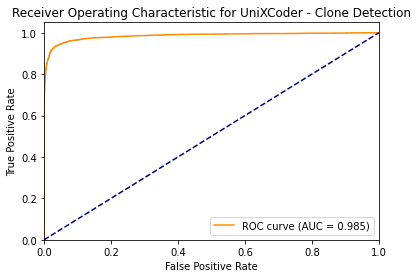

In [13]:
roc(y_true, clone_detection_scores, "UniXCoder - Clone Detection")

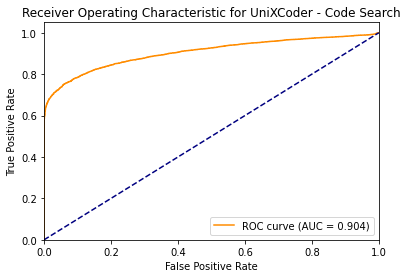

In [14]:
roc(y_true, code_search_scores, "UniXCoder - Code Search")

## Similarity score distribution

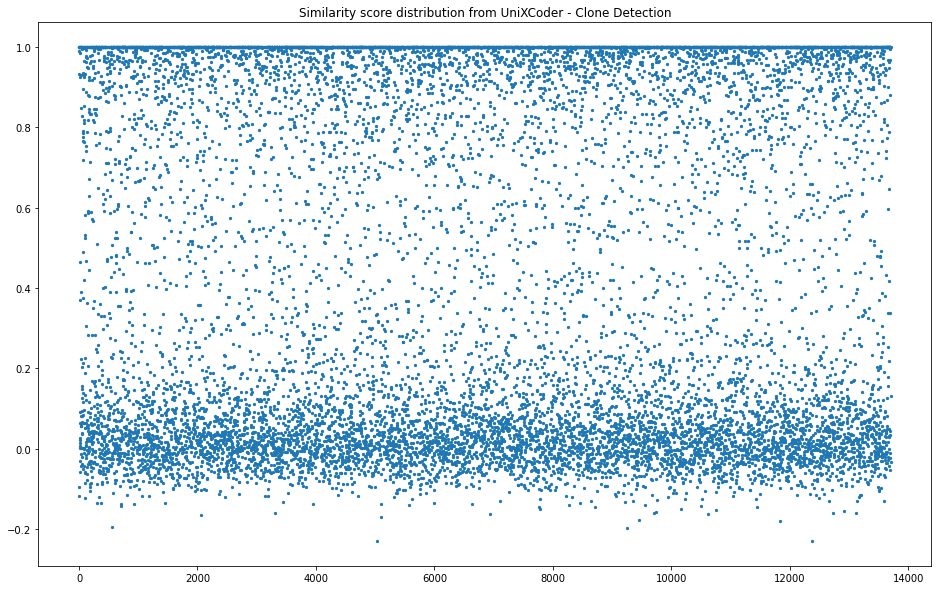

In [15]:
plt.figure(figsize=(16, 10))
plt.title('Similarity score distribution from UniXCoder - Clone Detection')
plt.scatter(clone_detection_scores.index, clone_detection_scores, s=5)

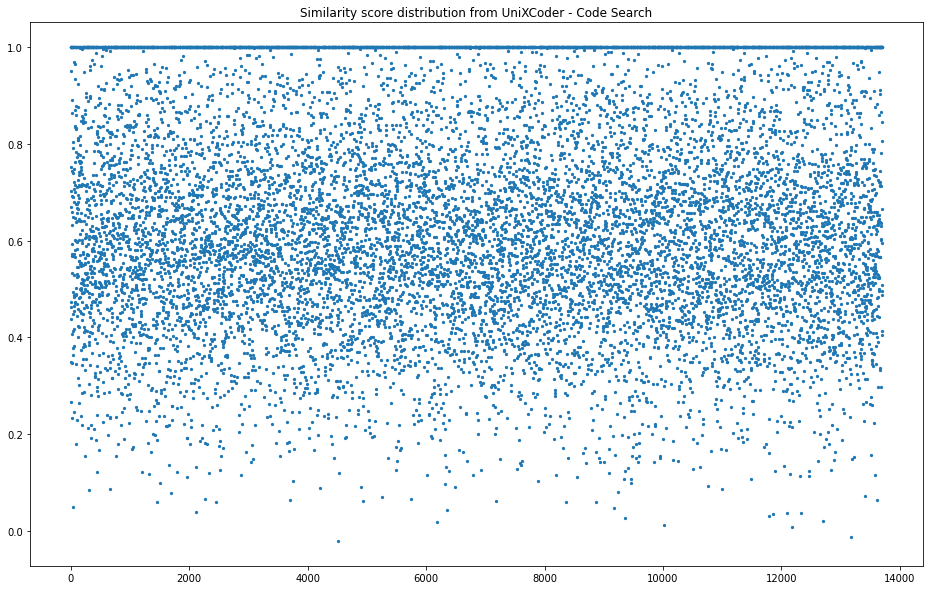

In [16]:
plt.figure(figsize=(16, 10))
plt.title('Similarity score distribution from UniXCoder - Code Search')
plt.scatter(code_search_scores.index, code_search_scores, s=5)